In [1]:
import os
# os.chdir(r'C:\Users\morel.DESKTOP-PJ169O3\Documents\TravailDeRecherche\Library')
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
import obspy
from scatcov.frontend import *

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from facvae.utils import datadir

/data/as356/envs/fac-vae/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths to raw Mars waveforms and the scattering covariance thereof.
MARS_PATH = datadir('mars')
MARS_RAW_PATH = datadir(os.path.join(MARS_PATH, 'raw'))

stream = obspy.read(os.path.join(MARS_RAW_PATH, "2019", "JUN", "06/06.UVW_calib_ACC.mseed"))

In [3]:
def windows(x, window_size, stride, offset):
    """ Separate x into windows on last axis, discard any residual.
    """
    num_window = int((x.shape[-1] - window_size - offset) // stride + 1)
    windowed_x = np.stack([
        x[..., i * stride + offset:window_size + i * stride + offset]
        for i in range(num_window)
    ], -2)  # (C) x nb_w x w

    return windowed_x

In [4]:
trace = stream[0][425000:480000]
background = windows(trace, 2048, 1024, 0)[2:]
glitch = stream[0][482800:482800+2048]
print(background.shape)

(50, 2048)


# Generate Synthetic Data

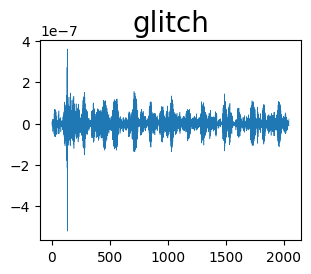

In [5]:
# sum two signals X1 + X2 where X2 is a "glitch"

R = 51
T = 2 ** 11

dataset = np.zeros([R, T])
dataset[0, :] = copy.copy(glitch)
dataset[1:, :] = copy.copy(background)

X1 = copy.copy(dataset[0, :])

# X2: transient localized event, a "glitch"
X2 = np.zeros(T)
X2[T//2-5:T//2] = -1
X2[T//2:T//2+100] = 2
X2[T//2+100:T//2+120] = -1
X2[T//2+120:T//2+160] = 1
X2 /= (X2**2).mean()**0.5
X2 *= 0.5 * np.std(X1)

# plot
plt.figure(figsize=(6,5))
plt.subplot2grid((2,2), (1, 0))
plt.plot(X1, linewidth=0.4)
plt.title('glitch', fontsize=20)
plt.tight_layout()

# Deglitch through gradient descent

In [6]:
# starting point
x0 = copy.copy(dataset[:R-1, :])

# x_deglitched is an candidate for X1
# x_deglitched starts from X1 + X2 and tries to match the statistics of X1
x_deglitched = generate(dataset[1:, :], x0=x0[:,None,:], Q=[4,4],
                        J=7, it=10000, tol_optim=5e-4, cuda=True, gpus=[2])[0,0,:]


Data saving dir: gen_scat_cov_battle_lemarie_B50_N1_T2048_J[7, 7]_Q1_4_Q2_4_rmax2_model_cov_tol5_00e_04_it10000
gen_scat_cov: generating data.
Initialize model
Preparing target representation
Embedding: uses 3908 coefficients spars=28 mean=1 ps=29 phaseenv=364 envelope=3486
     3it in 0:00:08.79 ( 0.34it/s ) .... err 5.59E-02 -- max 4.66E+00 -- maxpct 3589.835% -- gerr 5.58E+03

 -- spars           max 5.12e-01 -- meanpct 10.34% -- maxpct 71.8%, 
 -- mean            max 0.00e+00 -- meanpct 0.00% -- maxpct 0.0%, 
 -- ps              max 4.66e+00 -- meanpct 19.35% -- maxpct 466.4%, 
 -- phaseenv        max 5.77e-01 -- meanpct 424.27% -- maxpct 3589.8%, 
 -- envelope        max 7.55e-01 -- meanpct 18.02% -- maxpct 780.3%, 
     8it in 0:00:12.09 ( 0.66it/s ) .... err 4.09E-02 -- max 2.33E+00 -- maxpct 1773.486% -- gerr 9.19E+02

 -- spars           max 3.19e-01 -- meanpct 9.59% -- maxpct 43.8%, 
 -- mean            max 0.00e+00 -- meanpct 0.00% -- maxpct 0.0%, 
 -- ps              max 2.

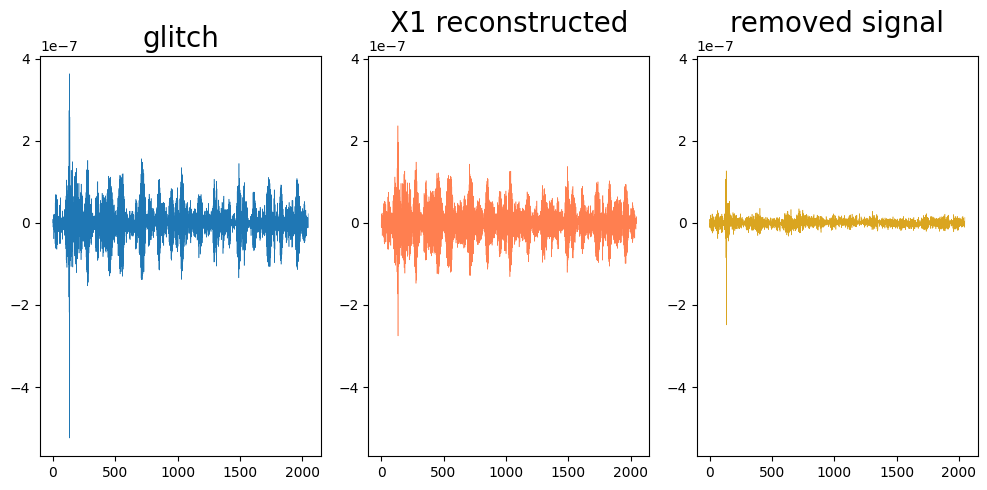

In [9]:
# ploting
plt.figure(figsize=(10,5))

ax = plt.subplot2grid((1, 3), (0, 0))
plt.plot(glitch, linewidth=0.4)
plt.title('glitch', fontsize=20)
lim = ax.get_ylim()

ax = plt.subplot2grid((1, 3), (0, 1))
plt.plot(x_deglitched, linewidth=0.4, color='coral')
plt.title('X1 reconstructed', fontsize=20)
plt.ylim(lim)


plt.subplot2grid((1, 3), (0, 2))
plt.plot(glitch - x_deglitched, linewidth=0.4, color='goldenrod')
plt.title('removed signal', fontsize=20)
plt.ylim(lim)
# plt.ylim(-0.1,0.13)


plt.tight_layout()